In [82]:
import operators as op
import qutip as qt
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from sympy import Matrix

In [83]:
def dagger(matrix):
    return matrix.conjugate().transpose()


def rotation_sympy(axis, angle):
    """
    Constructs a rotation operator using SymPy for a single qubit.

    Parameters:
        axis (str): 'x', 'y', or 'z' indicating the rotation axis.
        angle (Symbol or float): Rotation angle in radians.

    Returns:
        Matrix: The rotation operator as a SymPy matrix.
    """
    # Define Pauli matrices as SymPy matrices
    sigma_x = sp.Matrix([[0, 1], [1, 0]])
    sigma_y = sp.Matrix([[0, -sp.I], [sp.I, 0]])
    sigma_z = sp.Matrix([[1, 0], [0, -1]])
    
    # Select the correct axis
    if axis == 'x':
        pauli = sigma_x
    elif axis == 'y':
        pauli = sigma_y
    elif axis == 'z':
        pauli = sigma_z
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    # Compute the rotation operator
    return sp.exp(-sp.I * angle / 2 * pauli)


def rotation_qutip(axis, angle):
    """
    Constructs a rotation operator using QuTiP for a single qubit.

    Parameters:
        axis (str): 'x', 'y', or 'z' indicating the rotation axis.
        angle (float): Rotation angle in radians.

    Returns:
        Qobj: The rotation operator as a QuTiP quantum object.
    """
    # Define Pauli matrices as QuTiP Qobjs
    sigma_x = qt.sigmax()
    sigma_y = qt.sigmay()
    sigma_z = qt.sigmaz()
    
    # Select the correct axis
    if axis == 'x':
        pauli = sigma_x
    elif axis == 'y':
        pauli = sigma_y
    elif axis == 'z':
        pauli = sigma_z
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    # Compute the rotation operator
    return (-1j * angle / 2 * pauli).expm()

def process(matrix):
    """
    Converts a 4x4 matrix to SymPy form if it is a QuTiP Qobj.
    Leaves it unchanged if it is already a SymPy matrix.

    Parameters:
        matrix: Input matrix (Qutip.Qobj or SymPy.Matrix).

    Returns:
        SymPy.Matrix: The converted or unchanged SymPy matrix.
    """
    if isinstance(matrix, qt.Qobj):
        # Check if the Qobj is 4x4 based on its shape
        if matrix.shape == (4, 4):
            return sp.Matrix(matrix.full())
        else:
            raise ValueError("Input Qobj must be a 4x4 matrix.")
    elif isinstance(matrix, sp.Matrix):
        # If already a SymPy matrix, return it unchanged
        return matrix
    else:
        raise TypeError("Input must be either a Qutip Qobj or a SymPy Matrix.")

def FT(signal, times, abs=False, padding=None):
    """
    Computes the Fourier transform of the passed time-dependent signal.

    Parameters
    ----------
     - `signal`: array-like:
              Sampled signal to be transformed in the frequency domain (in a.u.).
    - `times`: array-like
             Sampled time domain (in microseconds).
    - `abs`: Boolean 
             Whether to return the absolute value of the computer Fourier transform. 
    - `padding`: Integer
             Amount of zero-padding to add to signal in the power of zeroes.
    
    Returns
    -------
    The frequency and fourier-transformed signal as a tuple (f, ft)
    """
    if padding is not None: 
        # This code by Stephen Carr
        nt = len(times) #number of points
        
        # zero pad the ends to "interpolate" in frequency domain
        zn = padding # power of zeros
        N_z = 2 * (2 ** zn) + nt # number of elements in padded array
        zero_pad = np.zeros(N_z, dtype=complex)
        
        M0_trunc_z = zero_pad
        num = 2 ** zn
        M0_trunc_z[num:(num + nt)] = signal
        
        # figure out the "frequency axis" after the FFT
        dt = times[2] - times[1]
        Fs = 1.0 / dt # max frequency sampling

        # axis goes from - Fs / 2 to Fs / 2, with N_z steps
        freq_ax = ((np.linspace(0, N_z, N_z) - 1/2) / N_z - 1/2) * Fs
        
        M_fft = np.fft.fftshift(np.fft.fft(np.fft.fftshift(M0_trunc_z)))
        if abs:
            M_fft = np.abs(M_fft)
        return freq_ax, M_fft

    ft = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(times), (times[-1] - times[0]) / len(times))
    if abs: 
        ft = np.abs(ft)
    return freq, ft

In [84]:
(Ix, Iy, Iz) = qt.spin_J_set(1/2) #note sigma_x and Ix are off by a factor of 2
a, b, c, d, t, J = sp.Symbol('a'), sp.Symbol('b'), sp.Symbol('c'), sp.Symbol('d'), sp.Symbol('t', real=True), sp.Symbol('J', real=True)
sigma_x = qt.sigmax()  # Pauli X
sigma_y = qt.sigmay()  # Pauli Y
sigma_z = qt.sigmaz()  # Pauli Z

Id = qt.qeye(2)
Id_sympy = sp.Matrix(Id.full())

CLEAN_1000=op.CLEAN_1000
rho_variable = sp.Matrix([[a, 0, 0, 0],[0, b, 0, 0],[0, 0, c, 0], [0, 0, 0, d]])
rho_thermal = sp.Matrix([[a, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0], [0, 0, 0, -a]])

Vs_Q1=1   #Voltage scale
Vs_Q2=1   #Voltage scale
Omega_1=0
Omega_2=-763.43

H= 2 * sp.pi * J * sp.Matrix(op.IzSz.full()) + Omega_1*sp.Matrix(op.Iz.full()) + Omega_2*sp.Matrix(op.Sz.full())

#There were errors with trying gto do tensor product in sympy and then reshape. More reliable to do with Qutip
R_x90=rotation_qutip('x', sp.pi/2)
R_y90=rotation_qutip('y', sp.pi/2)
R_minus_x90=rotation_qutip('x', -sp.pi/2)
R_minus_y90=rotation_qutip('y', -sp.pi/2)

In [85]:
pi=np.pi
rho_0 = sp.Matrix([[a, 0, 0, 0],[0, b, 0, 0],[0, 0, c, 0], [0, 0, 0, d]])
ta_1 = op.Rx_I(pi/2) * op.UJ * op.Rx_S(pi/2) * op.Ry_I(pi/2) * op.UJ * op.Ry_S(pi/2)
rho_1 = ta_1 * rho_variable * ta_1.dag()
rho_1 = rho_1.applyfunc(lambda x: sp.nsimplify(x, rational=False, tolerance=1e-10)) 
display(rho_1)

rho_variable = sp.Matrix([[a, 0, 0, 0],[0, b, 0, 0],[0, 0, c, 0], [0, 0, 0, d]])
ta_2 = op.Rx_S(pi/2) * op.UJ * op.Ry_S(pi/2) * op.Rx_I(pi/2) * op.UJ * op.Ry_I(pi/2)
rho_2 = ta_2 * rho_variable* ta_2.dag()
rho_2 = rho_2.applyfunc(lambda x: sp.nsimplify(x, rational=False, tolerance=1e-10)) 
display(rho_2)

Matrix([
[a, 0, 0, 0],
[0, c, 0, 0],
[0, 0, d, 0],
[0, 0, 0, b]])

Matrix([
[a, 0, 0, 0],
[0, d, 0, 0],
[0, 0, b, 0],
[0, 0, 0, c]])

# Define "rho" and "Readout_pulse"

In [86]:
rho=process(rho_0) #takes in standard qutip or Sympy form as used above

#Q1 Readout
Readout_pulse_Q1=R_x90 #This can be changed depending on the readout pulse. This can currently only take in spin 1 rotations

#Q2 Readout
Readout_pulse_Q2=Id#This can be changed depending on the readout pulse. This can currently only take in spin 1 rotations

In [87]:
Readout_Operator_Q1=sp.Matrix(qt.tensor(Readout_pulse_Q1,Id).full()) #This can currently only take in spin 1 rotations. #Note #Rx(π/2)⊗I is different from op.Ix
# Replace numerical approximations with exact values
Readout_Operator_Q1_Sympy = Readout_Operator_Q1.applyfunc(lambda x: sp.nsimplify(x, rational=False, tolerance=1e-10)) 
#display(Readout_Operator_Sympy)

Readout_Operator_Q2=sp.Matrix(qt.tensor(Id, Readout_pulse_Q2).full()) #This can currently only take in spin 1 rotations. #Note #Rx(π/2)⊗I is different from op.Ix
# Replace numerical approximations with exact values
Readout_Operator_Q2_Sympy = Readout_Operator_Q2.applyfunc(lambda x: sp.nsimplify(x, rational=False, tolerance=1e-10)) 
#display(Readout_Operator_Sympy)

In [88]:
M_Q1 = sp.simplify(- dagger(Readout_Operator_Q1_Sympy) * sp.exp(1j * H * t)  * sp.Matrix(qt.tensor(1j*sigma_x +sigma_y,Id).full()) * sp.exp(-1j * H * t) * Readout_Operator_Q1_Sympy)

M_Q2 = sp.simplify(- dagger(Readout_Operator_Q2_Sympy) * sp.exp(1j * H * t)  * sp.Matrix(qt.tensor(Id,1j*sigma_x +sigma_y).full()) * sp.exp(-1j * H * t) * Readout_Operator_Q2_Sympy)

In [89]:
display(M_Q1)
display(M_Q2)

Matrix([
[   1.0*exp(-3.14159265358979*I*J*t),                                  0, -1.0*I*exp(-3.14159265358979*I*J*t),                                  0],
[                                  0,    1.0*exp(3.14159265358979*I*J*t),                                   0, -1.0*I*exp(3.14159265358979*I*J*t)],
[-1.0*I*exp(-3.14159265358979*I*J*t),                                  0,   -1.0*exp(-3.14159265358979*I*J*t),                                  0],
[                                  0, -1.0*I*exp(3.14159265358979*I*J*t),                                   0,   -1.0*exp(3.14159265358979*I*J*t)]])

Matrix([
[                                                   0, 0,                                                   0, 0],
[-2.0*I*exp(-0.01*I*t*(314.159265358979*J - 76343.0)), 0,                                                   0, 0],
[                                                   0, 0,                                                   0, 0],
[                                                   0, 0, -2.0*I*exp(0.01*I*t*(314.159265358979*J + 76343.0)), 0]])

In [90]:
V_Q1 = Vs_Q1 * np.trace(rho*M_Q1)
display(V_Q1)

V_Q2 = Vs_Q2 * np.trace(rho*M_Q2)
display(V_Q2)

1.0*a*exp(-3.14159265358979*I*J*t) + 1.0*b*exp(3.14159265358979*I*J*t) - 1.0*c*exp(-3.14159265358979*I*J*t) - 1.0*d*exp(3.14159265358979*I*J*t)

0

In [91]:
a, b, c, d, t, J = sp.Symbol('a'), sp.Symbol('b'), sp.Symbol('c'), sp.Symbol('d'), sp.Symbol('t', real=True), sp.Symbol('J', real=True)
values = {a: 1, b: 0, c: 0, d: -1, J: 22}
rho = rho.subs(values)
M_Q1 = M_Q1.subs(values)
M_Q2 = M_Q2.subs(values)

V_Q1_values = Vs_Q1 * np.trace(rho*M_Q1)
V_Q2_values = Vs_Q2 * np.trace(rho*M_Q2)
display(V_Q1_values+V_Q2_values)

1.0*exp(69.1150383789754*I*t) + 1.0*exp(-69.1150383789754*I*t)

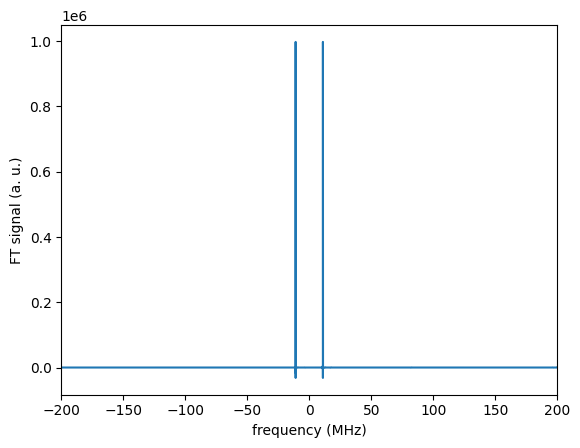

In [92]:
stop = 1000
times = np.linspace(start=0, stop=stop, num=int(stop*1000))

Vf_t = sp.lambdify(t, V_Q1_values+V_Q2_values, modules='numpy')
f0, ft0 = FT(Vf_t(times), times, padding=0)

abs_f = (np.absolute(ft0)/np.max(np.absolute(ft0)))**2
abs_f = (ft0/np.max(np.absolute(ft0)))
abs_f = ft0
# peaks = find_peaks(abs_f)
plt.plot(f0, abs_f)

colors = ['red', 'blue', 'green', 'orange']
# for index, ipeak in enumerate(peaks[0][1:]):
#     plt.plot(f[ipeak], abs_f[ipeak], marker="o", markersize=6, color = colors[index])

plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(-200, 200)
#plt.axvline(x=(11/(2*np.pi)), color='r', linestyle='--')
plt.show()

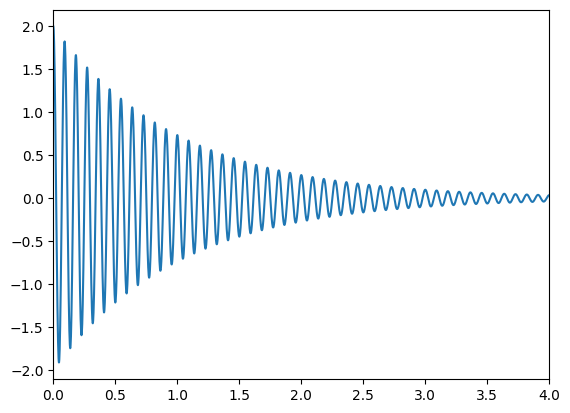

In [93]:
plt.plot(times, Vf_t(times)*np.e**-times)
plt.xlim(0, 4)
plt.show()

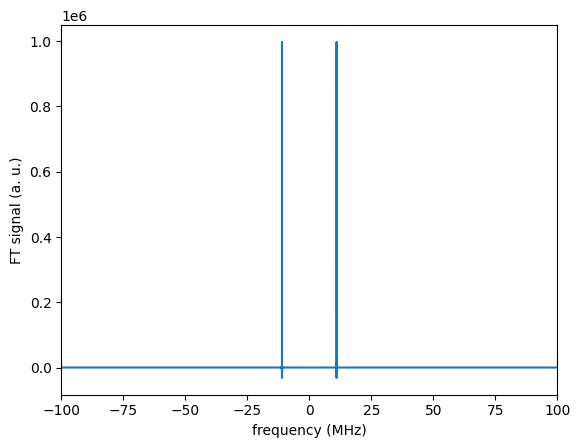

In [94]:
stop = 1000
times = np.linspace(start=0, stop=stop, num=int(stop*1000))

Vf_t = sp.lambdify(t, V_Q1_values+V_Q2_values, modules='numpy')
f0, ft0 = FT(Vf_t(times), times, padding=0)

abs_f = (np.absolute(ft0)/np.max(np.absolute(ft0)))**2
abs_f = (ft0/np.max(np.absolute(ft0)))
abs_f = ft0
# peaks = find_peaks(abs_f)
plt.plot(f0, abs_f)

colors = ['red', 'blue', 'green', 'orange']
# for index, ipeak in enumerate(peaks[0][1:]):
#     plt.plot(f[ipeak], abs_f[ipeak], marker="o", markersize=6, color = colors[index])

plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(-100, 100)
#plt.axvline(x=(11/(2*np.pi)), color='r', linestyle='--')
#plt.gca().invert_xaxis()
plt.show()